## [Lecture 9.2: Decision Trees for Regression](https://www.youtube.com/watch?v=wjVCvwgwSSg)

### Decision Trees for Regression

Decision Trees are capable of finding complex nonlinear relationships in the data. They can perform both classification and regression tasks.

In this notebook, we will demonstrate decision trees for regression tasks with California housing dataset and `DecisionTreeRegressor` class in `sklearn`

#### Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.tree import export_text

In [2]:
np.random.seed(306)

Let's use `ShuffleSplit` as cv with 10 splits with 20% examples set aside as test examples.

In [3]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

#### Load the dataset

In [4]:
# fetch the dataset
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)

# train-test-split
com_train_features, test_features, com_train_labels, test_labels = train_test_split(features,labels, random_state=42)

# train ---> train + dev split
train_features, dev_features, train_labels, dev_labels = train_test_split(com_train_features, com_train_labels, random_state=42)

#### Model setup


In [5]:
dt_reg_pipeline = Pipeline([('feature_scaling', StandardScaler()),
                            ('dt_reg', DecisionTreeRegressor(max_depth=3, random_state=42))])

dt_reg_cv_results = cross_validate(dt_reg_pipeline,
                                   com_train_features,
                                   com_train_labels,
                                   cv=cv,
                                   scoring='neg_mean_absolute_error',
                                   return_train_score=True,
                                   return_estimator=True)
dt_reg_train_error = -1 * dt_reg_cv_results['train_score']
dt_reg_test_error = -1 * dt_reg_cv_results['test_score']

print(f'Mean absolute error of Decision Tree regression model on the train set: \n'
      f'{dt_reg_train_error.mean():.3f} +/- {dt_reg_train_error.std():.3f}')
print(f'Mean absolute error of Decision Tree regression model on the test set: \n'
      f'{dt_reg_test_error.mean():.3f} +/- {dt_reg_test_error.std():.3f}')

Mean absolute error of Decision Tree regression model on the train set: 
0.590 +/- 0.005
Mean absolute error of Decision Tree regression model on the test set: 
0.593 +/- 0.007


#### Visualizing the tree
One of the advantages of using a decision tree classifier is that output is intuitive to understand and can be easily visualized. This can be done in two ways:
- As a tree diagram
- As a text based diagram

#### As a tree diagram
We need to call `fit`function on pipeline object before printing the tree

In [6]:
dt_reg_pipeline.fit(train_features, train_labels)

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('dt_reg',
                 DecisionTreeRegressor(max_depth=3, random_state=42))])

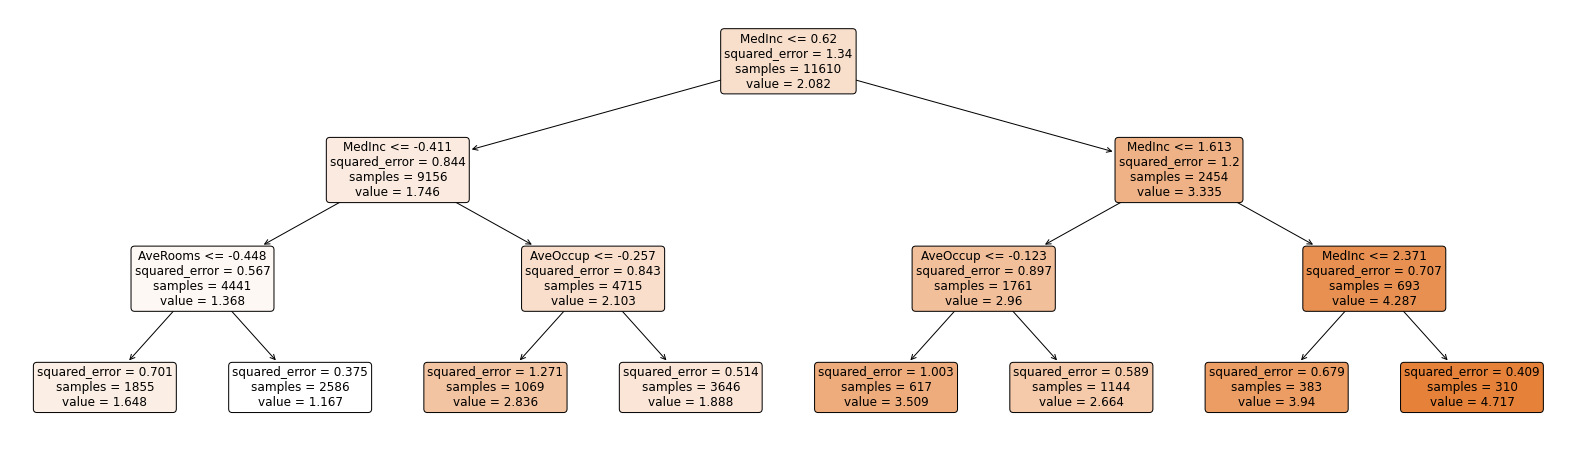

In [7]:
plt.figure(figsize=(28,8), facecolor='w')
# create the tree plot
a = tree.plot_tree(dt_reg_pipeline[-1],
                   # use the feature names stored
                   feature_names = features.columns,
                   rounded=True,
                   filled=True,
                   fontsize=12)
# show the plot
plt.show()

#### As a text-based diagram

In [8]:
# export the decision rules
tree_rules = export_text(dt_reg_pipeline[-1])
# print the result
print(tree_rules)

|--- feature_0 <= 0.62
|   |--- feature_0 <= -0.41
|   |   |--- feature_2 <= -0.45
|   |   |   |--- value: [1.65]
|   |   |--- feature_2 >  -0.45
|   |   |   |--- value: [1.17]
|   |--- feature_0 >  -0.41
|   |   |--- feature_5 <= -0.26
|   |   |   |--- value: [2.84]
|   |   |--- feature_5 >  -0.26
|   |   |   |--- value: [1.89]
|--- feature_0 >  0.62
|   |--- feature_0 <= 1.61
|   |   |--- feature_5 <= -0.12
|   |   |   |--- value: [3.51]
|   |   |--- feature_5 >  -0.12
|   |   |   |--- value: [2.66]
|   |--- feature_0 >  1.61
|   |   |--- feature_0 <= 2.37
|   |   |   |--- value: [3.94]
|   |   |--- feature_0 >  2.37
|   |   |   |--- value: [4.72]



#### Using the tree for prediction

In [9]:
test_labels_pred = dt_reg_pipeline.predict(test_features)

In [10]:
mae = mean_absolute_error(test_labels, test_labels_pred)
mse = mean_squared_error(test_labels, test_labels_pred)
r2 = r2_score(test_labels, test_labels_pred)

print('The model performance for testing set')
print('-------------------------------------')
print('MAE is :', mae)
print('MSE is :', mse)
print('R2 score is :', r2)

The model performance for testing set
-------------------------------------
MAE is : 0.6005762942842664
MSE is : 0.6417557936098145
R2 score is : 0.5150037690483743


Let us now try to improve the model by tuning the hyperparameters

In [11]:
param_grid = {'dt_reg__max_depth': range(1,20),
              'dt_reg__min_samples_split': range(2, 8)}
dt_grid_search = GridSearchCV(dt_reg_pipeline,
                              param_grid=param_grid,
                              n_jobs=2,
                              cv=cv,
                              scoring='neg_mean_absolute_error',
                              return_train_score=True)
dt_grid_search.fit(com_train_features, com_train_labels)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('feature_scaling', StandardScaler()),
                                       ('dt_reg',
                                        DecisionTreeRegressor(max_depth=3,
                                                              random_state=42))]),
             n_jobs=2,
             param_grid={'dt_reg__max_depth': range(1, 20),
                         'dt_reg__min_samples_split': range(2, 8)},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [12]:
mean_train_error = -1 * dt_grid_search.cv_results_['mean_train_score'][dt_grid_search.best_index_]
mean_test_error = -1 * dt_grid_search.cv_results_['mean_test_score'][dt_grid_search.best_index_]
std_train_error = -1 * dt_grid_search.cv_results_['std_train_score'][dt_grid_search.best_index_]
std_test_error = -1 * dt_grid_search.cv_results_['std_test_score'][dt_grid_search.best_index_]

print(f'Best Mean absolute error of Decision Tree regression model on the train set: \n'
      f'{mean_train_error:.3f} +/- {std_train_error:.3f}')
print(f'Best absolute error of Decision Tree regression model on the test set: \n'
      f'{mean_test_error:.3f} +/- {std_test_error:.3f}')

Best Mean absolute error of Decision Tree regression model on the train set: 
0.278 +/- -0.006
Best absolute error of Decision Tree regression model on the test set: 
0.428 +/- -0.012


In [13]:
print('Mean cross validated score of the best estimator is:', -1*dt_grid_search.best_score_)

Mean cross validated score of the best estimator is: 0.4283313044233501


In [14]:
print('The best parameter value is: ', dt_grid_search.best_params_)

The best parameter value is:  {'dt_reg__max_depth': 11, 'dt_reg__min_samples_split': 5}


Let's retrain the model with the best hyperparameter value

In [15]:
dt_reg_pipeline.set_params(
    dt_reg__max_depth=11, dt_reg__min_samples_split=5).fit(com_train_features, com_train_labels)

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('dt_reg',
                 DecisionTreeRegressor(max_depth=11, min_samples_split=5,
                                       random_state=42))])

In [16]:
test_labels_pred = dt_reg_pipeline.predict(test_features)
mae = mean_absolute_error(test_labels, test_labels_pred)
mse = mean_squared_error(test_labels, test_labels_pred)
r2 = r2_score(test_labels, test_labels_pred)

print('The model performance for testing set')
print('-------------------------------------')
print('MAE is :', mae)
print('MSE is :', mse)
print('R2 score is :', r2)

The model performance for testing set
-------------------------------------
MAE is : 0.4248952183820017
MSE is : 0.4154957726373763
R2 score is : 0.6859960039130073


## [Lecture 9.3: Decision Trees for classification - Abalone](https://www.youtube.com/watch?v=SBnT0B2e5kc)

### **Decision Trees using Pipelines**

#### Import basic libraries

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split

#### Loading the data set
In this lecture, we will use the Abalone data set for classification

Abalone is a type of consumable snail whose price varies as per its age. The aim is to predict the age of abalone from physical measurements. The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope - a boring and time-consuming task. Other measurements, which are easier to obtain, are used to predict the age.

In [18]:
column_names = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Schucked weight', 'Viscera weight', 'Shell weight', 'Rings']
abalone_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data', header=None, names=column_names)

Let's now see the type and name of the features:
- **Sex**: This is gender of the abalone and has categorical value (M, F, or I)
- **Length**: The longest measurement of the abalone shell in mm. Continous numeric value
- **Diameter**: The measurement of the shell perpenticular to the length in mm. Continous numeric value
- **Height**: Height of the shell in mm. Continous numeric value.
- **Weight**: Weight of the abalone in grams. Continous numeric value.
- **Shucked weight**: Weight of the meat in the abalone in grams. Continous numeric value.
- **Viscera weight**: Weight of the abalone after bleeding in grams. Continous numeric value.
- **Shell weight**: Weight of the abalone after being dried in grams. Continous numeric value.
- **Rings**: This is the target, that is the feature that we will train the model to predict. As mentioned earlier, we are interested in age of the abalone and it has been established that number of rings + 1.5 gives the age. Discrete numeric value.

In [19]:
type(abalone_data)

pandas.core.frame.DataFrame

#### Examining the data set.

In [20]:
abalone_data.shape

(4177, 9)

In [21]:
abalone_data.head(10)

,Sex,Length,Diameter,Height,Whole weight,Schucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
5,I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8
6,F,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.330,20
7,F,0.545,0.425,0.125,0.7680,0.2940,0.1495,0.260,16
8,M,0.475,0.370,0.125,0.5095,0.2165,0.1125,0.165,9
9,F,0.550,0.440,0.150,0.8945,0.3145,0.1510,0.320,19


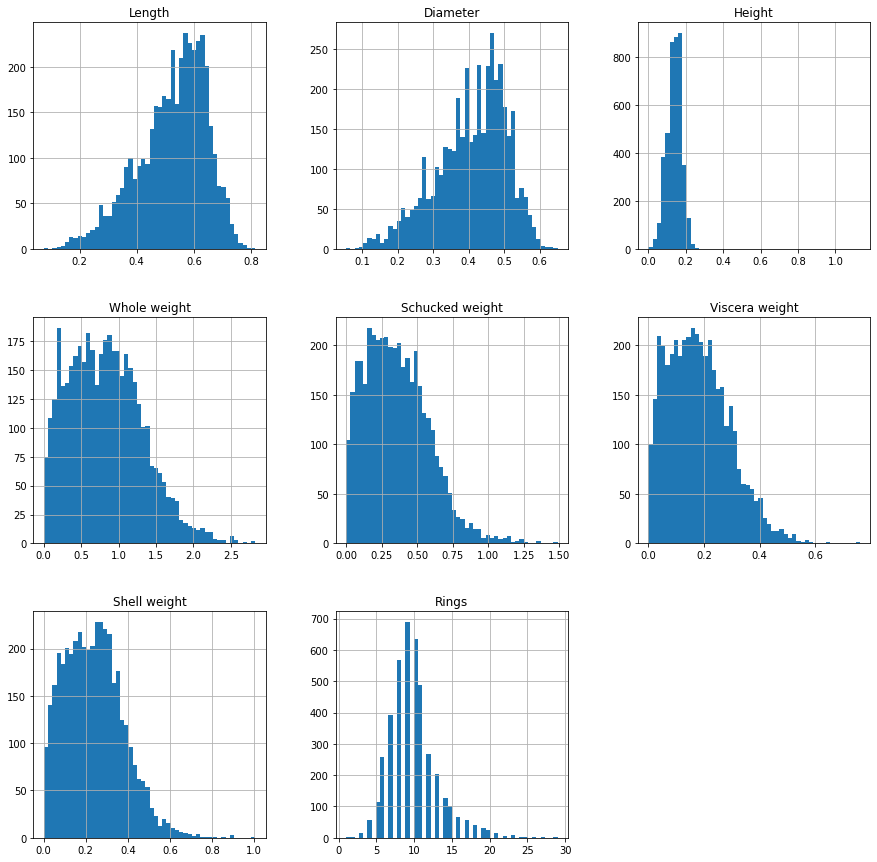

In [22]:
abalone_data.hist(bins=50, figsize=(15,15))
# display histogram
plt.show()

<Figure size 432x288 with 0 Axes>

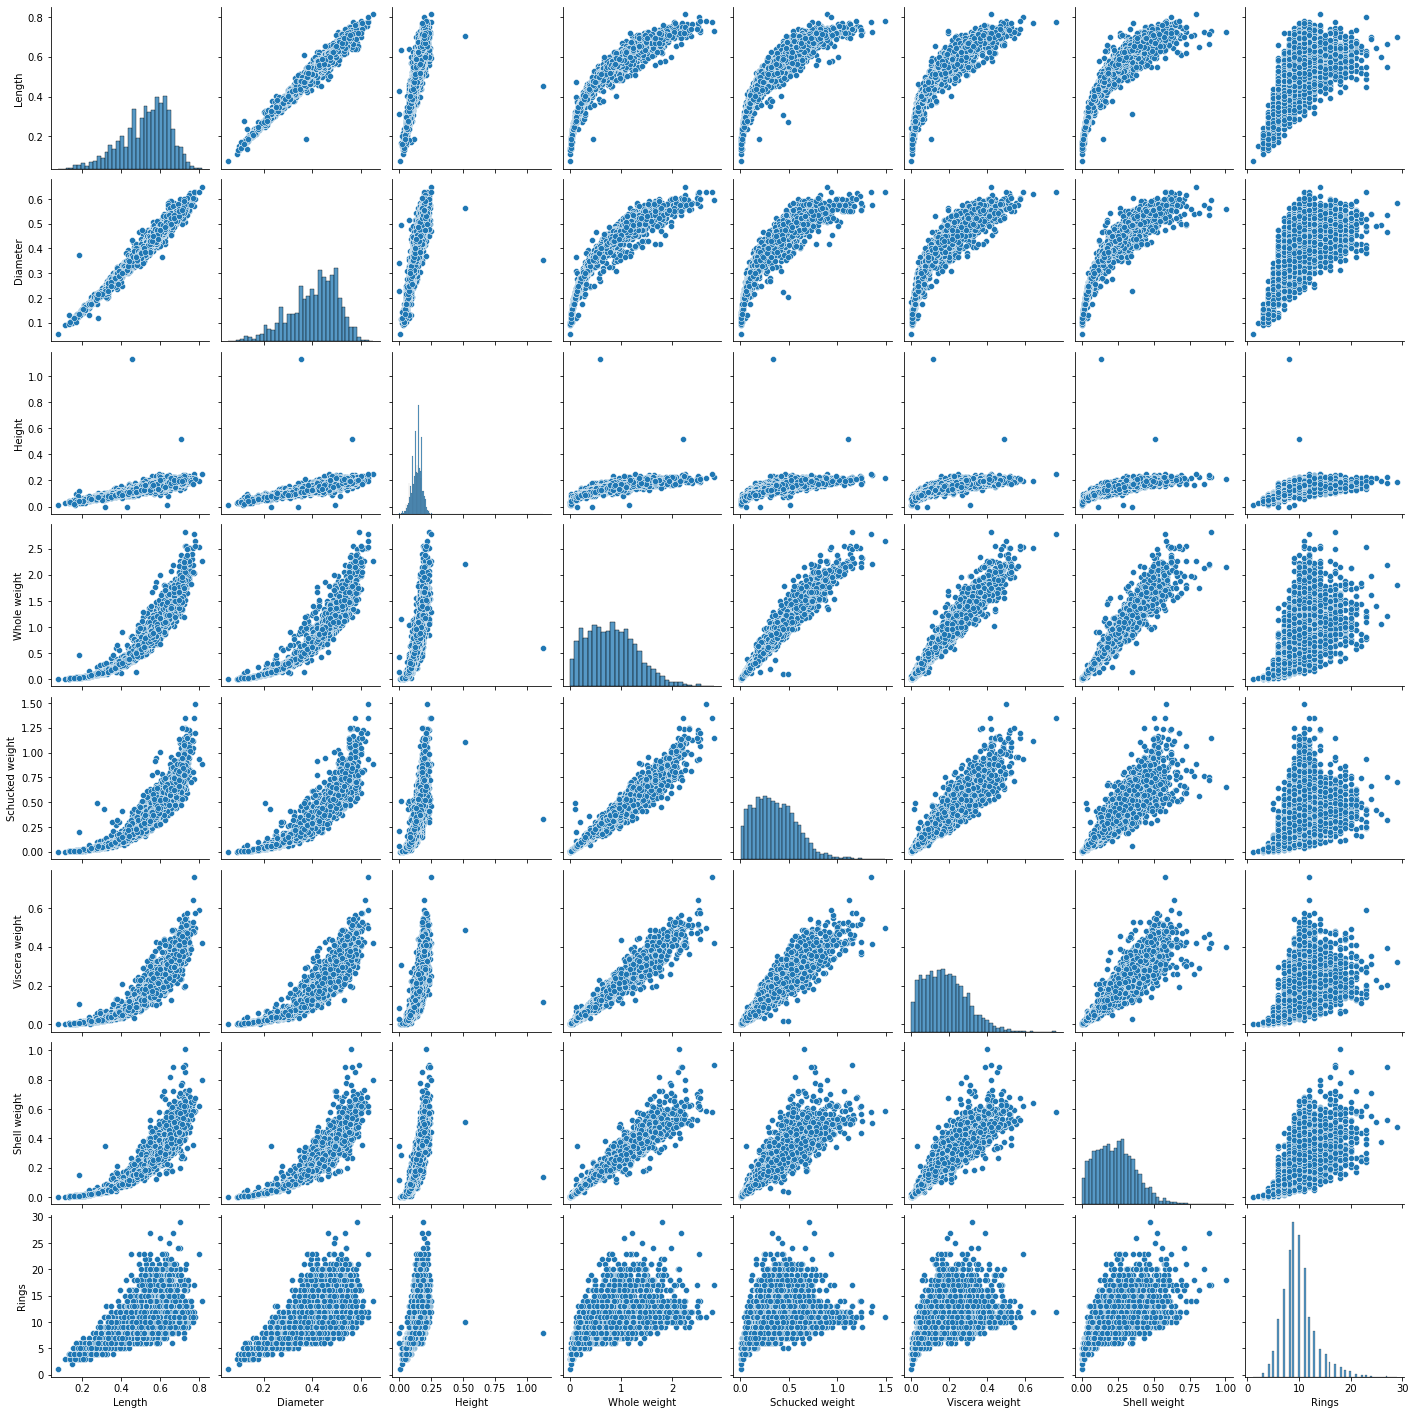

In [23]:
plt.figure()
sns.pairplot(abalone_data, diag_kind='hist')
plt.show()

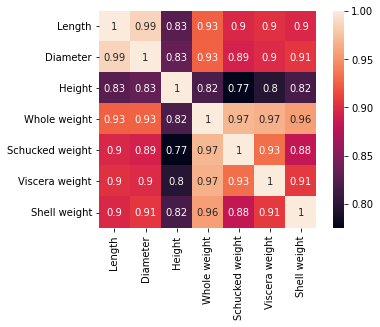

In [24]:
plt.figure()
sns.heatmap(abalone_data.iloc[:, :-1].corr(), annot=True, square=True)
plt.show()

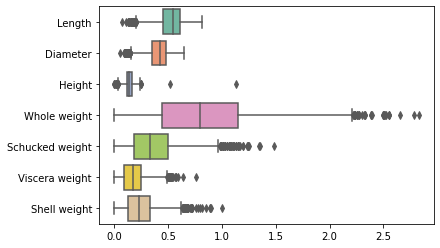

In [25]:
plt.figure()
sns.boxplot(data=abalone_data.iloc[:, :-1], orient='h', palette='Set2')
plt.show()

We find the different features to be having different ranges through this box-plot, which indicates that scaling the features may be useful

In [26]:
abalone_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Sex              4177 non-null   object 
 1   Length           4177 non-null   float64
 2   Diameter         4177 non-null   float64
 3   Height           4177 non-null   float64
 4   Whole weight     4177 non-null   float64
 5   Schucked weight  4177 non-null   float64
 6   Viscera weight   4177 non-null   float64
 7   Shell weight     4177 non-null   float64
 8   Rings            4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


From the information above, all the features are continous except for the Sex feature

In [27]:
abalone_data.describe()

,Length,Diameter,Height,Whole weight,Schucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


The count shows that there are no missing values 

However, in the height feature, the minimum value is zero. This possibility calls for a missing value in the data and we will process the missing value.

Next, take a look at the target in this case in the Rings column

In [28]:
abalone_data['Rings'].unique()

array([15,  7,  9, 10,  8, 20, 16, 19, 14, 11, 12, 18, 13,  5,  4,  6, 21,
       17, 22,  1,  3, 26, 23, 29,  2, 27, 25, 24])

In [29]:
abalone_data['Rings'].value_counts().sort_index()

1       1
2       1
3      15
4      57
5     115
6     259
7     391
8     568
9     689
10    634
11    487
12    267
13    203
14    126
15    103
16     67
17     58
18     42
19     32
20     26
21     14
22      6
23      9
24      2
25      1
26      1
27      2
29      1
Name: Rings, dtype: int64

#### Missing values (or 0 values)

We first check how many missing values are in the height feature and which class is it in

In [30]:
(abalone_data['Height'] == 0).sum()

2

In [31]:
abalone_data[abalone_data['Height'] ==0]

,Sex,Length,Diameter,Height,Whole weight,Schucked weight,Viscera weight,Shell weight,Rings
1257,I,0.430,0.34,0.0,0.428,0.2065,0.0860,0.1150,8
3996,I,0.315,0.23,0.0,0.134,0.0575,0.0285,0.3505,6


The number of missing values is 2 and is in the infant sex. Then we change the value 0 to null. We will fill in the missing value with the average height feature for the infant gender

In [32]:
means = pd.pivot_table(abalone_data, index = ['Sex'], aggfunc = {'Height': np.mean})
means

,Height
Sex,
F,0.158011
I,0.107996
M,0.151381


So we will fill in the missing value with 0.107996. ( Will do this while during preprocessing)

#### Storing the data in the form of X and y

In [33]:
X = abalone_data.iloc[:, :-1]
y = abalone_data.iloc[:, -1]

#### Splitting the data into train and test sets

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#### Pipelining

We will use pipelines to perform preprocessing of the data, which will include: handling missing (or 0) values, scaling the features and handling the categorical feature (viz., sex in this case)

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

#### Identifying the numeric and categorical features ( to be able to preprocess them differently)

In [36]:
numeric_features = ['Length', 'Diameter', 'Height', 'Whole weight', 'Schucked weight', 'Viscera weight', 'Shell weight']
categorical_features = ['Sex']

In [37]:
numeric_transformer = Pipeline(
    steps=[('imputer', SimpleImputer(missing_values=0, strategy='constant', fill_value=0.107996)),
           ('scaler', StandardScaler())]
)

In [38]:
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

In [39]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [40]:
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier(max_depth=3, random_state=42))])

In [41]:
clf.fit(X_train, y_train)
print('model score: %.3f'%clf.score(X_test, y_test))

model score: 0.245


In [42]:
y_pred = clf.predict(X_test)

Let us compare the actual and predicted values  of y.

In [43]:
comparision = np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.values.reshape(len(y_test),1)),1)

for each in comparision:
    print(each)

[10 13]
[8 8]
[10 11]
[4 5]
[10 12]
[10 11]
[9 7]
[8 8]
[7 7]
[10  9]
[7 8]
[5 8]
[ 9 11]
[8 9]
[5 4]
[10  7]
[9 7]
[10 17]
[10  7]
[7 7]
[7 7]
[7 5]
[8 8]
[9 9]
[10 10]
[10 10]
[4 5]
[11 15]
[ 8 10]
[10 14]
[9 8]
[4 4]
[10  9]
[11 13]
[7 7]
[8 7]
[7 8]
[10  9]
[7 8]
[10 11]
[ 8 15]
[ 8 12]
[ 8 17]
[10 16]
[10 11]
[ 8 11]
[9 8]
[10 10]
[10 11]
[7 6]
[10 13]
[7 7]
[ 9 13]
[11 20]
[ 8 12]
[9 7]
[5 8]
[ 9 10]
[7 7]
[7 7]
[10  9]
[9 9]
[ 9 11]
[7 8]
[7 7]
[11 12]
[11 13]
[10 17]
[8 8]
[11 12]
[8 9]
[11 17]
[10 10]
[8 6]
[ 8 11]
[8 8]
[10  8]
[8 9]
[10  8]
[8 8]
[10  8]
[5 6]
[7 7]
[10 13]
[ 8 11]
[7 6]
[10  9]
[11 12]
[4 5]
[7 6]
[ 9 11]
[ 8 11]
[9 8]
[7 7]
[10 16]
[5 8]
[ 8 11]
[9 8]
[10 18]
[10 11]
[10 12]
[ 8 14]
[10 12]
[10 11]
[5 6]
[10  9]
[7 7]
[7 6]
[ 7 11]
[10 11]
[11 11]
[11 12]
[ 8 20]
[ 9 10]
[10 14]
[11 10]
[10 10]
[10 12]
[5 4]
[ 8 12]
[7 7]
[10 13]
[7 6]
[8 8]
[10 17]
[10 15]
[10  9]
[10 11]
[7 7]
[10 11]
[10  8]
[9 7]
[8 7]
[10 10]
[11 11]
[10  9]
[ 8 10]
[8 9]
[7 8]
[11 16

In [44]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix \n', cm)

Confusion Matrix 
 [[ 0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  5  5  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  7 14  0 10  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1 12  0 28  4  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  3  0 56 13 22  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  3  0 25 43 28 13  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  7 47 24 47  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  4 22 17 49 15  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2 20 14 45 14  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1 17  3 30 15  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  8  2 18 10  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 12  0 11  3  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  4  1  8  5  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  4  0  5  4  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


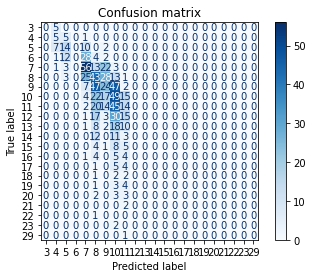

In [45]:
# visualizing the confusion matrix

from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.show()

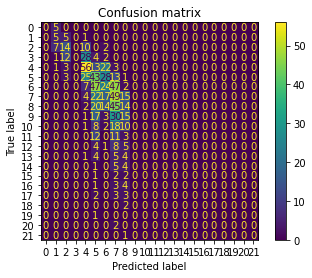

In [46]:
# visualizing the confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_test_predicted = clf.predict(X_test)
cm = confusion_matrix(y_test, y_test_predicted)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title('Confusion matrix')
plt.show()

In [47]:
from sklearn.metrics import classification_report
CR = classification_report(y_test, y_pred)
print('Classification Report \n')
print(CR)

Classification Report 

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.26      0.45      0.33        11
           5       0.38      0.42      0.40        33
           6       0.00      0.00      0.00        47
           7       0.41      0.57      0.48        98
           8       0.21      0.38      0.27       113
           9       0.21      0.19      0.20       127
          10       0.20      0.46      0.28       107
          11       0.16      0.15      0.16        95
          12       0.00      0.00      0.00        66
          13       0.00      0.00      0.00        39
          14       0.00      0.00      0.00        26
          15       0.00      0.00      0.00        18
          16       0.00      0.00      0.00        14
          17       0.00      0.00      0.00        10
          18       0.00      0.00      0.00         5
          19       0.00      0.00      0.00         8
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
from sklearn.model_selection import cross_val_score
acc = cross_val_score(estimator=clf, X=X_train, y=y_train,cv=10)
print(type(acc))
print('Accuracy of each fold', list(acc*100))
print('Accuracy : {:.2f}%'.format(acc.mean()*100))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  UserWarning,


<class 'numpy.ndarray'>
Accuracy of each fold [27.46268656716418, 22.45508982035928, 23.952095808383234, 24.550898203592812, 24.251497005988025, 23.952095808383234, 25.449101796407188, 30.83832335329341, 26.34730538922156, 26.047904191616766]
Accuracy : 25.53%


#### Visualizing the Decision Trees

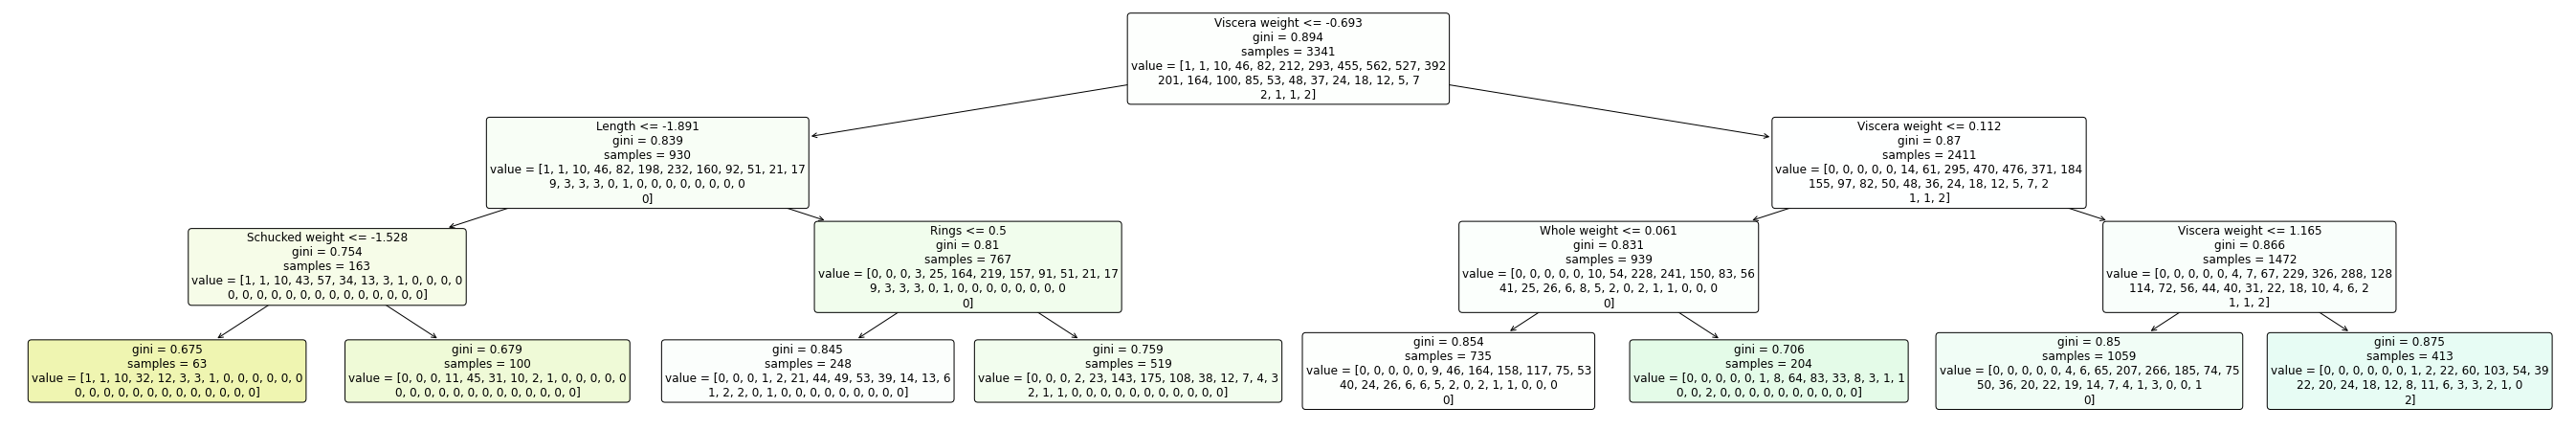

In [50]:
from sklearn import tree

# plt the figure, setting a blank background
plt.figure(figsize=(48,8),facecolor='w')

# create the tree plot
a = tree.plot_tree(clf['classifier'],
                   # use the feature names stored
                   feature_names=column_names,
                   rounded=True,
                   filled=True,
                   fontsize=12)
# show the plot
plt.show()

#### Finding the best parameter using GridSearchCV


In [51]:
X_train_new = preprocessor.fit_transform(X_train)

In [52]:
from sklearn.model_selection import GridSearchCV

tuned_parameters = [{'max_depth':range(1,10),
                     'min_samples_split': [2,4,6,8,10]}]
scores = ['recall']
for score in scores:
    print()
    print(f'Tuning hyperparameters for {score}')
    print()

    clf_CV = GridSearchCV(DecisionTreeClassifier(),
                          tuned_parameters,
                          scoring = f'{score}_macro')
    clf_CV.fit(X_train_new, y_train)

    print('Best parameters')
    print()
    print(clf_CV.best_params_)
    print()
    print('Grid scores:')
    means = clf_CV.cv_results_['mean_test_score']
    stds = clf_CV.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf_CV.cv_results_['params']):
        print(f'{mean:0.3f} +/- {std*2:0.03f} for {params}')


Tuning hyperparameters for recall



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavio

Best parameters

{'max_depth': 5, 'min_samples_split': 4}

Grid scores:
0.073 +/- 0.009 for {'max_depth': 1, 'min_samples_split': 2}
0.073 +/- 0.009 for {'max_depth': 1, 'min_samples_split': 4}
0.073 +/- 0.009 for {'max_depth': 1, 'min_samples_split': 6}
0.073 +/- 0.009 for {'max_depth': 1, 'min_samples_split': 8}
0.073 +/- 0.009 for {'max_depth': 1, 'min_samples_split': 10}
0.107 +/- 0.011 for {'max_depth': 2, 'min_samples_split': 2}
0.107 +/- 0.011 for {'max_depth': 2, 'min_samples_split': 4}
0.107 +/- 0.011 for {'max_depth': 2, 'min_samples_split': 6}
0.107 +/- 0.011 for {'max_depth': 2, 'min_samples_split': 8}
0.107 +/- 0.011 for {'max_depth': 2, 'min_samples_split': 10}
0.131 +/- 0.012 for {'max_depth': 3, 'min_samples_split': 2}
0.131 +/- 0.012 for {'max_depth': 3, 'min_samples_split': 4}
0.131 +/- 0.012 for {'max_depth': 3, 'min_samples_split': 6}
0.131 +/- 0.012 for {'max_depth': 3, 'min_samples_split': 8}
0.131 +/- 0.012 for {'max_depth': 3, 'min_samples_split': 10}
0.134 +/- 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Let us now create a new pipeline using the best features identified above

In [53]:
# Append classifier to preprocessing pipeline
# Now we have a full prediction pipeline
clf2 = Pipeline(
    steps=[('preprocessor', preprocessor),
           ('classifier', DecisionTreeClassifier(max_depth=5, min_samples_split=4,random_state=42))]
)

In [54]:
clf2.fit(X_train, y_train)
print('Model score: %.3f'%clf2.score(X_test, y_test))

Model score: 0.272


We observe an improvement in the model score

## [Lecture 9.4: Decision Trees for Classification - Iris](https://www.youtube.com/watch?v=3Lc7sD1Dj4Q)

Here we will demonstrate **decision tree** in **classification** setup with **Iris dataset**.

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

Let's load Iris dataset with `load_iris` API

In [57]:
features, labels = load_iris(return_X_y=True, as_frame=True)

Let's split the data into train and test set

In [58]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=42)

Define the decision tree classifier as part of `pipeline`.

In [59]:
dt_pipeline = Pipeline(steps=[('feature_scaling', MinMaxScaler()),
                              ('dt_classifier', DecisionTreeClassifier(max_depth=3, random_state=42))])

In [60]:
dt_pipeline.fit(train_features, train_labels)

Pipeline(steps=[('feature_scaling', MinMaxScaler()),
                ('dt_classifier',
                 DecisionTreeClassifier(max_depth=3, random_state=42))])

Now that the classifier is trained, let's evaluate it on the test set with
- Confusion matrix
- Classification report

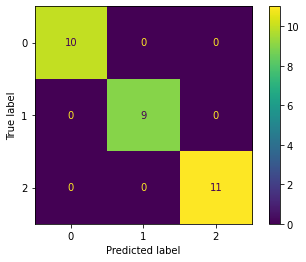

In [61]:
ConfusionMatrixDisplay.from_estimator(dt_pipeline, test_features, test_labels)

In [62]:
print(classification_report(test_labels, dt_pipeline.predict(test_features)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



As a next step let's visualize the trained decision tree model

In [63]:
data = load_iris()

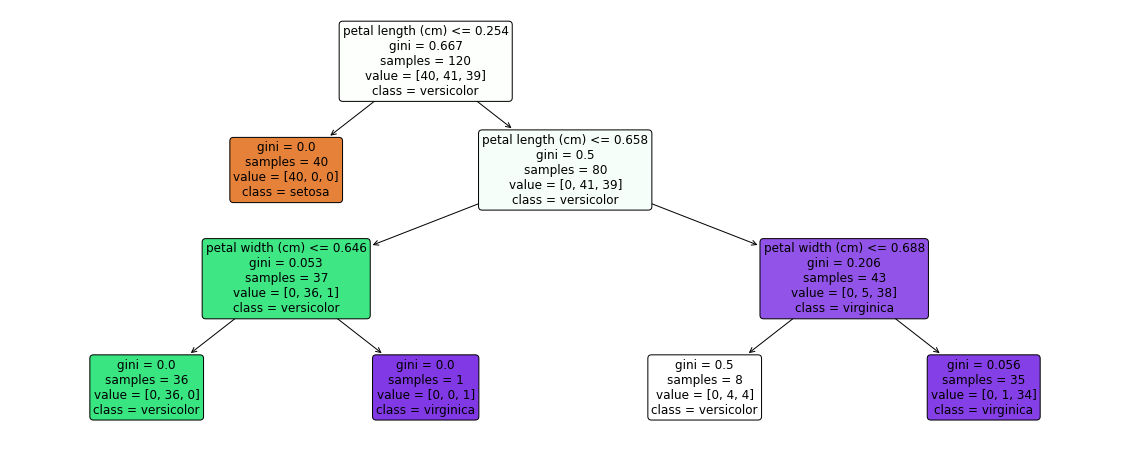

In [65]:
# plot the figure
plt.figure(figsize=(20,8), facecolor='w')
# create a tree plot
a = tree.plot_tree(dt_pipeline[-1],
                   # use the feature names stored
                   feature_names = features.columns,
                   # use the class names stored
                   class_names = data.target_names,
                   rounded = True,
                   filled = True,
                   fontsize = 12)
# Show the plot
plt.show()

In [66]:
# export the decision rules
tree_rules = export_text(dt_pipeline[-1],
                         feature_names=list(features.columns))
# print the result
print(tree_rules)

|--- petal length (cm) <= 0.25
|   |--- class: 0
|--- petal length (cm) >  0.25
|   |--- petal length (cm) <= 0.66
|   |   |--- petal width (cm) <= 0.65
|   |   |   |--- class: 1
|   |   |--- petal width (cm) >  0.65
|   |   |   |--- class: 2
|   |--- petal length (cm) >  0.66
|   |   |--- petal width (cm) <= 0.69
|   |   |   |--- class: 1
|   |   |--- petal width (cm) >  0.69
|   |   |   |--- class: 2



Let's get the feature importance from the trained decision tree model

In [69]:
# extract importance
importance = pd.DataFrame({'feature': features.columns,
                           'importance':np.round(dt_pipeline[-1].feature_importances_, 3)})
importance.sort_values('importance', ascending=False,inplace=True)
print(importance)

             feature  importance
2  petal length (cm)       0.935
3   petal width (cm)       0.065
0  sepal length (cm)       0.000
1   sepal width (cm)       0.000


There are two configurable parameters in the tree classifier:
- `max_depth`
- `min_samples_split`

In [70]:
hp_grid = [{'dt_classifier__max_depth':[1,2,3,4,5],
            'dt_classifier__min_samples_split':[2,4,6,8,10]}]
gs_clf = GridSearchCV(dt_pipeline, hp_grid, scoring='f1_macro')
gs_clf.fit(train_features, train_labels)

print('Best parameters: ')
print()
print(gs_clf.best_params_)
print()
print('Grid scores:')
means = gs_clf.cv_results_['mean_test_score']
stds = gs_clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gs_clf.cv_results_['params']):
        print(f'{mean:0.3f} +/- {std*2:0.03f} for {params}')

Best parameters: 

{'dt_classifier__max_depth': 4, 'dt_classifier__min_samples_split': 2}

Grid scores:
0.559 +/- 0.014 for {'dt_classifier__max_depth': 1, 'dt_classifier__min_samples_split': 2}
0.559 +/- 0.014 for {'dt_classifier__max_depth': 1, 'dt_classifier__min_samples_split': 4}
0.559 +/- 0.014 for {'dt_classifier__max_depth': 1, 'dt_classifier__min_samples_split': 6}
0.559 +/- 0.014 for {'dt_classifier__max_depth': 1, 'dt_classifier__min_samples_split': 8}
0.559 +/- 0.014 for {'dt_classifier__max_depth': 1, 'dt_classifier__min_samples_split': 10}
0.916 +/- 0.091 for {'dt_classifier__max_depth': 2, 'dt_classifier__min_samples_split': 2}
0.916 +/- 0.091 for {'dt_classifier__max_depth': 2, 'dt_classifier__min_samples_split': 4}
0.916 +/- 0.091 for {'dt_classifier__max_depth': 2, 'dt_classifier__min_samples_split': 6}
0.916 +/- 0.091 for {'dt_classifier__max_depth': 2, 'dt_classifier__min_samples_split': 8}
0.916 +/- 0.091 for {'dt_classifier__max_depth': 2, 'dt_classifier__min_samp

Confusion matrix for the best estimator obtained through the GridSearchCV

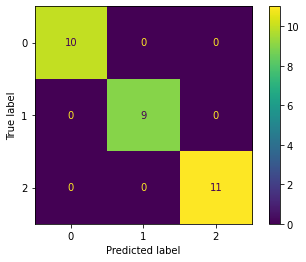

In [71]:
ConfusionMatrixDisplay.from_estimator(gs_clf.best_estimator_, test_features, test_labels)